# In-hospital length of stay

Prediction of hospitaliztion length of stay (LOS), can be a proxy to patients illness severity, and can be considered as a possible risk stratification model - the longer a patient is expected to be hospitalized, the more severe his status, and he may be prone to complications. In addition, longer stay costs money, increases the burden on the healthcare system and on the medical staff. Prediction of the expected LOS on the first day of hospitalization, can help with managing the available resources.

In this example, we simulate a dataset of 10,000 hospitalized patietns such that:

$\mbox{Admission Year} \sim \mbox{Uniform}(2000,2014)$

$\mbox{Gender} \sim \mbox{Bernoullie}(0.5), \qquad$ (1 is Female, 0 is Male)

$\mbox{Age} \sim \mbox{Normal}(72+5*\mbox{gender}\;,\;12)$ (years)

$\mbox{Height} \sim \mbox{Normal}(175-5*\mbox{gender}\;,\;7)$ (cm) 

$\mbox{Weight} \sim \mbox{Normal}(\frac{\mbox{height}}{175}*80 - 5 * \mbox{gender} + \frac{\mbox{age}}{20}\;,\;8)$ (kg)

$\mbox{BMI} \: (\mbox{Body} \: \mbox{Mass} \: \mbox{Index}) = \frac{\mbox{Weight}}{(\frac{\mbox{Height}}{100})^2}$ (kg/m^2)

$\mbox{Admission Serial} \sim \mbox{LogNormal}(0, 0.75)$

$\mbox{Smoking Status} \sim \mbox{Categorial(No, Previously, Currently)} \quad p=[0.5, 0.3, 0.2]$



We sample preconditions based on:

$\mbox{General_p} = 0.003 * \mbox{bmi} - 0.15 * \mbox{gender} + 0.002 * \mbox{age} + 0.1 * \mbox{smoking}$

$\mbox{Preconditions_p} = max( min(\mbox{General_p}, 0.65), 0.05)$ 

$\mbox{Hypertension} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Diabetes} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.003*\mbox{BMI})$

$\mbox{Arterial Fibrillation} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Chronic Obstructive Pulmonary Disease} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.1*\mbox{smoking})$

$\mbox{Chronic Renal Failure} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$


In Hospital Death (IHD) indicator: 

$\mbox{General_p} = 0.25 * \mbox{Preconditions_p} + 0.1 * (\mbox{Hypertension} + \mbox{Diabetes} + \mbox{Artfib} + \mbox{COPD} + \mbox{CRF})$ 

$\mbox{IHD_p} = max( min(\mbox{General_p}, 0.35), 0.05)$

$\mbox{IHD} \sim \mbox{Bernoulli(IHD_p)}$ 


and finally, for each patient we sample the length of hospitalization in days:

$Baseline Hazard \sim Exp(8)$

$\beta X = 0.1 * \mbox{age} - 0.1 * \mbox{gender} + 0.2 * \mbox{BMI} + 0.2 * \mbox{smoking} + 0.2 * \mbox{sum}(preconditions)$ (Partial Hazard)

$\mbox{Length-Of-Stay} = Baseline Hazard * Exp(\beta X)$

After sampling the LOS, for some patients we remove weight (and BMI) information based on year of admission, to reflect missingness which can occur in real world data.  

## Generating Simulation Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)
from pydts.examples_utils.simulations_data_config import *
from pydts.examples_utils.datasets import load_LOS_simulated_data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
data_df = load_LOS_simulated_data()

## Data Description

In [3]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ptno,10000.0,4999.500000,2886.895680,0.000000,2499.750000,4999.500000,7499.250000,9999.000000
Height,10000.0,172.594358,7.482167,145.985926,167.593182,172.590990,177.643625,201.645298
Weight,4562.0,80.190057,9.276063,45.565831,73.914932,80.292028,86.402282,112.808483
admserial,10000.0,1.500400,1.058448,1.000000,1.000000,1.000000,2.000000,17.000000
admyear,10000.0,2007.090900,4.308723,2000.000000,2003.000000,2007.000000,2011.000000,2014.000000
af,10000.0,0.234900,0.423958,0.000000,0.000000,0.000000,0.000000,1.000000
age,10000.0,74.356990,12.368707,13.800000,66.075000,74.400000,82.500000,122.600000
bmi,4562.0,26.950589,2.994033,16.572709,24.867803,26.833685,28.941256,40.233805
copd,10000.0,0.293100,0.455207,0.000000,0.000000,0.000000,1.000000,1.000000
crf,10000.0,0.229100,0.420275,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
import tableone as to
columns = [AGE_COL, GENDER_COL, WEIGHT_COL, HEIGHT_COL, BMI_COL, *preconditions, RETURNING_PATIENT_COL]
categorical = [GENDER_COL, *preconditions, RETURNING_PATIENT_COL]
groupby = ADMISSION_YEAR_COL
mytable = to.TableOne(data_df, columns, categorical, groupby)
mytable

Grouped by admyear                                                                                                                                                                                                                
                                        Missing      Overall       2000.0       2001.0       2002.0       2003.0       2004.0       2005.0       2006.0       2007.0       2008.0       2009.0       2010.0       2011.0       2012.0       2013.0       2014.0
n                                                      10000          608          648          655          674          707          649          639          680          673          662          656          705          660          691          693
age, mean (SD)                                0  74.4 (12.4)  74.7 (12.8)  74.9 (12.3)  74.1 (12.6)  74.5 (13.0)  74.2 (12.1)  73.8 (12.0)  74.1 (12.4)  74.3 (12.0)  74.6 (12.4)  74.6 (12.7)  75.4 (12.4)  74.7 (12.3)  73.9 (11.9)  73.3 (12.1)  74.5 (12.6)
sex, n (%)               0.0                  0  5064 (50.6)   309 (50.8)   318 (49.1)   337 (51.5)   324 (48.1)   361 (51.1)   348 (53.6)   322 (50.4)   327 (48.1)   342 (50.8)   342 (51.7)   300 (45.7)   371 (52.6)   358 (54.2)   357 (51.7)   348 (50.2)
                         1.0                     4936 (49.4)   299 (49.2)   330 (50.9)   318 (48.5)   350 (51.9)   346 (48.9)   301 (46.4)   317 (49.6)   353 (51.9)   331 (49.2)   320 (48.3)   356 (54.3)   334 (47.4)   302 (45.8)   334 (48.3)   345 (49.8)
Weight, mean (SD)                          5438   80.2 (9.3)   78.7 (9.5)   80.0 (8.3)   80.7 (8.7)   79.6 (9.4)   79.4 (8.7)   80.4 (9.8)   80.1 (8.8)   80.4 (9.2)   80.8 (9.5)   79.5 (9.4)   80.3 (9.5)   80.3 (9.2)   80.3 (8.6)   80.5 (9.6)   80.2 (9.5)
Height, mean (SD)                             0  172.6 (7.5)  172.4 (7.1)  172.7 (7.8)  172.9 (7.6)  172.2 (7.7)  172.9 (7.4)  172.5 (7.7)  172.6 (7.6)  172.5 (7.5)  173.0 (7.5)  172.6 (7.4)  172.1 (7.2)  172.6 (7.5)  172.8 (7.4)  172.5 (7.5)  172.7 (7.3)
bmi, mean (SD)                             5438   27.0 (3.0)   26.6 (3.0)   26.6 (2.8)   26.7 (2.9)   26.8 (2.9)   26.7 (2.7)   27.1 (3.1)   27.1 (3.1)   27.1 (3.1)   27.0 (3.0)   26.7 (2.8)   27.0 (3.0)   27.0 (3.0)   26.9 (2.9)   27.1 (3.0)   26.9 (3.0)
smk, n (%)               0.0                  0  5064 (50.6)   290 (47.7)   291 (44.9)   320 (48.9)   351 (52.1)   349 (49.4)   318 (49.0)   303 (47.4)   345 (50.7)   352 (52.3)   360 (54.4)   337 (51.4)   358 (50.8)   363 (55.0)   358 (51.8)   369 (53.2)
                         1.0                     3012 (30.1)   193 (31.7)   228 (35.2)   185 (28.2)   193 (28.6)   224 (31.7)   205 (31.6)   204 (31.9)   209 (30.7)   193 (28.7)   176 (26.6)   199 (30.3)   212 (30.1)   179 (27.1)   206 (29.8)   206 (29.7)
                         2.0                     1924 (19.2)   125 (20.6)   129 (19.9)   150 (22.9)   130 (19.3)   134 (19.0)   126 (19.4)   132 (20.7)   126 (18.5)   128 (19.0)   126 (19.0)   120 (18.3)   135 (19.1)   118 (17.9)   127 (18.4)   118 (17.0)
htn, n (%)               0.0                  0  7760 (77.6)   482 (79.3)   508 (78.4)   501 (76.5)   551 (81.8)   547 (77.4)   495 (76.3)   487 (76.2)   539 (79.3)   547 (81.3)   497 (75.1)   515 (78.5)   522 (74.0)   500 (75.8)   530 (76.7)   539 (77.8)
                         1.0                     2240 (22.4)   126 (20.7)   140 (21.6)   154 (23.5)   123 (18.2)   160 (22.6)   154 (23.7)   152 (23.8)   141 (20.7)   126 (18.7)   165 (24.9)   141 (21.5)   183 (26.0)   160 (24.2)   161 (23.3)   154 (22.2)
dm, n (%)                0.0                  0  6835 (68.3)   410 (67.4)   425 (65.6)   440 (67.2)   446 (66.2)   473 (66.9)   454 (70.0)   456 (71.4)   460 (67.6)   478 (71.0)   444 (67.1)   479 (73.0)   486 (68.9)   448 (67.9)   468 (67.7)   468 (67.5)
                         1.0                     3165 (31.6)   198 (32.6)   223 (34.4)   215 (32.8)   228 (33.8)   234 (33.1)   195 (30.0)   183 (28.6)   220 (32.4)   195 (29.0)   218 (32.9

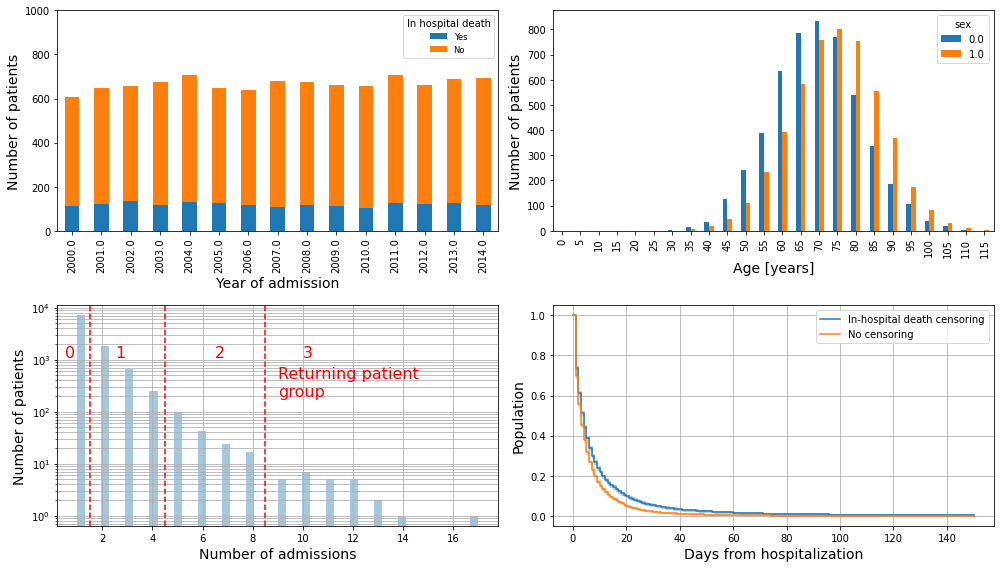

In [16]:
from pydts.examples_utils.plots import *
plot_LOS_simulation_figure1(data_df)

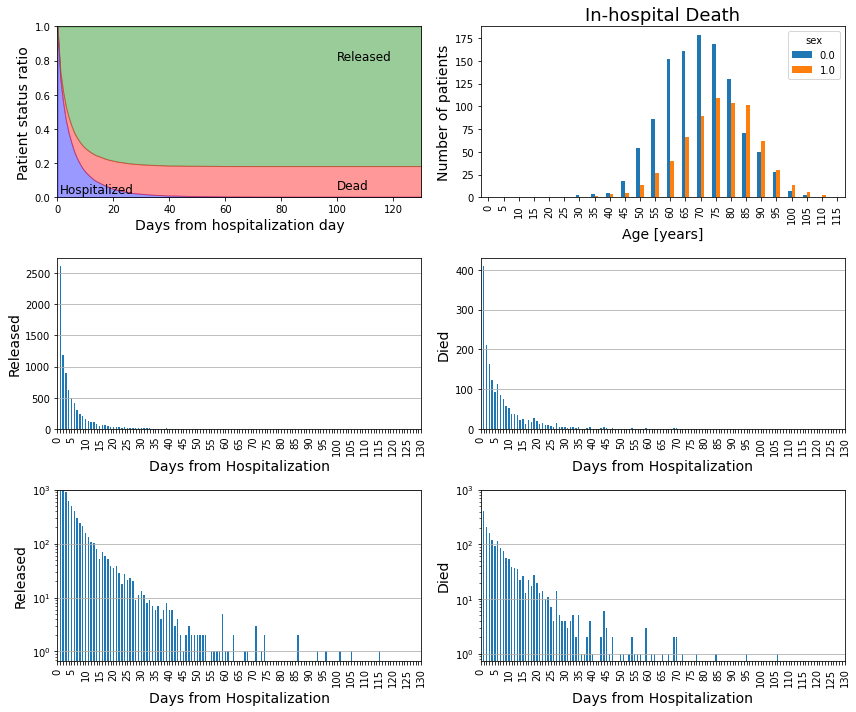

In [6]:
plot_LOS_simulation_figure2(data_df)

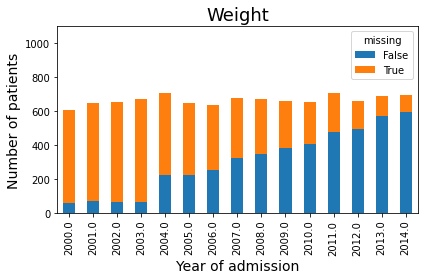

In [7]:
plot_LOS_simulation_figure3(data_df)

In [8]:
outcome_cols = [
    DISCHARGE_RELATIVE_COL,
    IN_HOSPITAL_DEATH_COL,
    DEATH_RELATIVE_COL, 
    DEATH_MISSING_COL
]

y = data_df.set_index(PATIENT_NO_COL)[outcome_cols]
X = data_df.set_index(PATIENT_NO_COL).drop(columns=outcome_cols)
X.drop([ADMISSION_SERIAL_COL, FIRST_ADMISSION_COL], axis=1, inplace=True)

## Missing Values Imputation

In [9]:
to_impute = X.isna().sum(axis=0).to_frame("value").query("value > 0").index
to_impute

Index(['Weight', 'bmi'], dtype='object')

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(verbose=1, strategy='median')
X[to_impute] = imputer.fit_transform(X[to_impute])

## Normalization

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

to_normalize = [HEIGHT_COL, WEIGHT_COL, AGE_COL, BMI_COL]
to_minmax = [RETURNING_PATIENT_COL, SMOKING_COL]

std_scaler = StandardScaler() 
X[to_normalize] = std_scaler.fit_transform(X[to_normalize])

minmax_scaler = MinMaxScaler()
X[to_minmax] = minmax_scaler.fit_transform(X[to_minmax])

X.head()

,Height,Weight,admyear,af,age,bmi,copd,crf,dm,htn,sex,smk,returning_patient
ptno,,,,,,,,,,,,,
0.0,0.180434,0.007425,2001.0,0.0,-0.489727,-0.026365,1.0,0.0,0.0,0.0,1.0,0.5,0.0
1.0,-0.789502,-0.915267,2013.0,0.0,1.224361,-0.034387,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2.0,0.692310,-0.739765,2013.0,0.0,0.213696,-1.464370,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3.0,0.053670,0.622183,2011.0,1.0,-0.732287,0.607377,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4.0,-0.620964,-1.845163,2011.0,0.0,-0.497813,-1.253706,0.0,0.0,1.0,1.0,0.0,0.5,0.0


In [12]:
y[IN_HOSPITAL_DEATH_COL] = y[IN_HOSPITAL_DEATH_COL] +1
y.head()

,dischargerelative_date,inhospital_death,death_relative_date_in_hosp,death_date_in_hosp_missing
ptno,,,,
0.0,2.0,1.0,NaN,1
1.0,20.0,1.0,NaN,1
2.0,1.0,1.0,NaN,1
3.0,11.0,1.0,NaN,1
4.0,1.0,1.0,NaN,1


## Fit

In [13]:
fit_df = pd.concat([X.drop(ADMISSION_YEAR_COL, axis=1), 
                    y[[IN_HOSPITAL_DEATH_COL, DISCHARGE_RELATIVE_COL]]], axis=1).reset_index()
fit_df.head()

,ptno,Height,Weight,af,age,bmi,copd,crf,dm,htn,sex,smk,returning_patient,inhospital_death,dischargerelative_date
0,0.0,0.180434,0.007425,0.0,-0.489727,-0.026365,1.0,0.0,0.0,0.0,1.0,0.5,0.0,1.0,2.0
1,1.0,-0.789502,-0.915267,0.0,1.224361,-0.034387,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,20.0
2,2.0,0.692310,-0.739765,0.0,0.213696,-1.464370,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,3.0,0.053670,0.622183,1.0,-0.732287,0.607377,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,11.0
4,4.0,-0.620964,-1.845163,0.0,-0.497813,-1.253706,0.0,0.0,1.0,1.0,0.0,0.5,0.0,1.0,1.0


In [14]:
regrouped_df = fit_df.copy()
regrouped_df[DISCHARGE_RELATIVE_COL].clip(upper=30, inplace=True)

In [15]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=regrouped_df, event_type_col=IN_HOSPITAL_DEATH_COL, duration_col=DISCHARGE_RELATIVE_COL, 
               pid_col=PATIENT_NO_COL)
fitter.print_summary()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Model summary for event: 1.0


<lifelines.CoxPHFitter: fitted with 55408 total observations, 47200 right-censored observations>
             duration col = 'dischargerelative_date'
                event col = 'j_1.0'
                   strata = dischargerelative_date_copy
      baseline estimation = breslow
   number of observations = 55408
number of events observed = 8208
   partial log-likelihood = -66442.40
         time fit was run = 2022-04-09 22:52:45 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Height              0.06       1.06       0.02             0.03             0.09                 1.03                 1.09
Weight             -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
af                 -0.51       0.60       0.03            -0.57            -0.46                 0.57                 0.63
age                -0.11       0.90       0.01            -0.13            -0.09                 0.88                 0.92
bmi                -0.08       0.92       0.02            -0.12            -0.04                 0.88                 0.96
copd               -0.48       0.62       0.03            -0.54            -0.43                 0.58                 0.65
crf                -0.50       0.60       0.03            -0.56            -0.45                 0.57                 0.64
dm                 -0.55       0.58       0.03            -0.60            -0.50                 0.55                 0.60
htn                -0.48       0.62       0.03            -0.54            -0.43                 0.58                 0.65
sex                 0.27       1.31       0.03             0.22             0.32                 1.25                 1.38
smk                -0.39       0.68       0.03            -0.46            -0.33                 0.63                 0.72
returning_patient   0.02       1.02       0.06            -0.10             0.15                 0.90                 1.16

                       z      p   -log2(p)
covariate                                 
Height              3.68 <0.005      12.07
Weight             -1.55   0.12       3.05
af                -18.06 <0.005     239.84
age                -9.63 <0.005      70.51
bmi                -4.14 <0.005      14.83
copd              -17.49 <0.005     225.22
crf               -17.45 <0.005     224.09
dm                -21.67 <0.005     343.46
htn               -16.79 <0.005     207.68
sex                10.40 <0.005      81.77
smk               -11.95 <0.005     106.89
returning_patient   0.35   0.73       0.46
---
Concordance = 0.71
Partial AIC = 132908.80
log-likelihood ratio test = 3355.44 on 12 df
-log2(p) of ll-ratio test = inf

n_jt  success  alpha_jt
inhospital_death dischargerelative_date                         
1.0              1.0                     2609     True -0.500124
                 2.0                     1185     True -0.953108
                 3.0                      899     True -0.938861
                 4.0                      627     True -1.034170
                 5.0                      491     True -1.036629
                 6.0                      410     True -0.981732
                 7.0                      299     True -1.081978
                 8.0                      243     True -1.087703
                 9.0                      213     True -1.007138
                 10.0                     155     True -1.146025
                 11.0                     133     True -1.122928
                 12.0                     109     True -1.142975
                 13.0                     105     True -1.004546
                 14.0                      79     True -1.141620
                 15.0                      52     True -1.462141
                 16.0                      69     True -1.021783
                 17.0                      59     True -1.061876
                 18.0                      53     True -1.024814
                 19.0                      38     True -1.227939
                 20.0                      35     True -1.168034
                 21.0                      39     True -0.917382
                 22.0                      29     True -1.083589
                 23.0                      18     True -1.457401
                 24.0                      27     True -0.922433
                 25.0                      21     True -1.059247
                 26.0                      23     True -0.846396
                 27.0                      20     True -0.871146
                 28.0                       9     True -1.522885
                 29.0                      11     True -1.235459
                 30.0                     148     True  2.705190



Model summary for event: 2.0


<lifelines.CoxPHFitter: fitted with 55408 total observations, 53616 right-censored observations>
             duration col = 'dischargerelative_date'
                event col = 'j_2.0'
                   strata = dischargerelative_date_copy
      baseline estimation = breslow
   number of observations = 55408
number of events observed = 1792
   partial log-likelihood = -14403.38
         time fit was run = 2022-04-09 22:52:47 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Height              0.05       1.05       0.03            -0.01             0.12                 0.99                 1.12
Weight             -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.09
af                  0.15       1.16       0.05             0.05             0.25                 1.05                 1.28
age                -0.09       0.92       0.02            -0.14            -0.04                 0.87                 0.96
bmi                -0.07       0.94       0.04            -0.15             0.02                 0.86                 1.02
copd                0.03       1.03       0.05            -0.07             0.14                 0.93                 1.14
crf                 0.02       1.02       0.05            -0.08             0.12                 0.92                 1.13
dm                  0.05       1.06       0.05            -0.04             0.15                 0.96                 1.16
htn                -0.00       1.00       0.05            -0.11             0.10                 0.90                 1.10
sex                 0.06       1.06       0.06            -0.06             0.17                 0.94                 1.18
smk                -0.07       0.93       0.07            -0.20             0.06                 0.82                 1.06
returning_patient  -0.19       0.83       0.14            -0.46             0.08                 0.63                 1.08

                      z      p   -log2(p)
covariate                                
Height             1.57   0.12       3.11
Weight            -0.04   0.97       0.04
af                 2.86 <0.005       7.88
age               -3.61 <0.005      11.69
bmi               -1.53   0.13       2.98
copd               0.60   0.55       0.86
crf                0.43   0.67       0.59
dm                 1.10   0.27       1.88
htn               -0.09   0.93       0.11
sex                0.97   0.33       1.60
smk               -1.08   0.28       1.84
returning_patient -1.38   0.17       2.58
---
Concordance = 0.55
Partial AIC = 28830.75
log-likelihood ratio test = 39.74 on 12 df
-log2(p) of ll-ratio test = 13.62

n_jt  success  alpha_jt
inhospital_death dischargerelative_date                         
2.0              1.0                      409     True -3.211901
                 2.0                      211     True -3.523623
                 3.0                      163     True -3.559430
                 4.0                      122     True -3.639079
                 5.0                       93     True -3.731129
                 6.0                      114     True -3.345883
                 7.0                       85     True -3.460563
                 8.0                       76     True -3.417108
                 9.0                       57     True -3.562146
                 10.0                      53     True -3.483925
                 11.0                      38     True -3.689932
                 12.0                      37     True -3.593882
                 13.0                      35     True -3.529621
                 14.0                      22     True -3.866666
                 15.0                      26     True -3.595861
                 16.0                      13     True -4.211206
                 17.0                      22     True -3.575148
                 18.0                      17     True -3.722881
                 19.0                      27     True -3.137824
                 20.0                      20     True -3.327525
                 21.0                      13     True -3.662970
                 22.0                      14     True -3.470972
                 23.0                      10     True -3.709990
                 24.0                      11     True -3.542098
                 25.0                       7     True -3.885997
                 26.0                       4     True -4.356527
                 27.0                      14     True -2.989868
                 28.0                       5     True -3.916024
                 29.0                       4     True -4.094554
                 30.0                      70     True -0.792820